In [54]:
import pygraphviz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch

In [44]:
def get_adj_matrix(dot_file_path):
    G = pygraphviz.AGraph()
    G.read(dot_file_path)
    adj_matrix = []
    for node in G.nodes():
        # get adjacency values per node (*1) turns Bool to value 1 or 0
        row = [G.has_edge(node, other_node)*1 for other_node in G.nodes()]
        adj_matrix.append(row)
    return np.array(adj_matrix)

def get_adj_list(dot_file_path):
    G = pygraphviz.AGraph()
    G.read(dot_file_path)
    adj_list = {}
    for node in G.nodes():
        adj_list[node] = [other_node for other_node in G.nodes() if G.has_edge(node, other_node)]
    return adj_list

In [51]:
dot_file_path = "../Datasets/LesMiserables.dot"

In [52]:
adj_matrix = get_adj_matrix(dot_file_path)
adj_list = get_adj_list(dot_file_path)

In [82]:
# N nodes
N = len(adj_matrix)

def circular_layout(N, center=(0, 0), radius=1):
    cx, cy = center
    positions = []
    for i in range(N):
        theta = 2 * np.pi * i / N
        x = cx + radius * np.cos(theta)
        y = cy + radius * np.sin(theta)
        positions.append((x, y))
    return positions

def random_layout(N, x_range = (0,1), y_range= (0,1)):
    positions = []
    for i in range(N):
        x = 0 # random value
        y = 0 # random value
    return positions



def plot_circular_graph(adj_matrix):

    # get graph size
    N = len(adj_matrix)

    # get circular node positions
    positions = circular_layout(N)

    fig = plt.figure(figsize=(5,5))
    ax = fig.gca()

    custom_xlim = (-1.2, 1.2)
    custom_ylim = (-1.2, 1.2)
    ax.set_xlim(custom_xlim)
    ax.set_ylim(custom_ylim)


    node_radius = .025 # get proportionate node size to graph size and bounding box !
    edge_lw = .1 # also proportionate?

    # draw nodes based on positions
    for pos in positions:
        ax.add_patch(Circle(xy=pos,radius= node_radius))
        #plt.scatter(pos[0], pos[1], c='blue', s = 30 )

    # draw edges based on adjacency matrix
    for i in range(N): # loop over rows
        for j in range(N): # loop over columns
            if adj_matrix[i, j] == 1: # check if nodes are adjacent
                start_edge = positions[i] # (some_x, some_y)
                end_edge = positions[j] # (some_x, some_y)

                ax.add_patch(ConnectionPatch(start_edge,end_edge,'data',lw=edge_lw))
                #plt.plot([start_edge[0], end_edge[0]], [start_edge[1], end_edge[1]], c ="gray", ls= '-', lw = .05)


    plt.show();


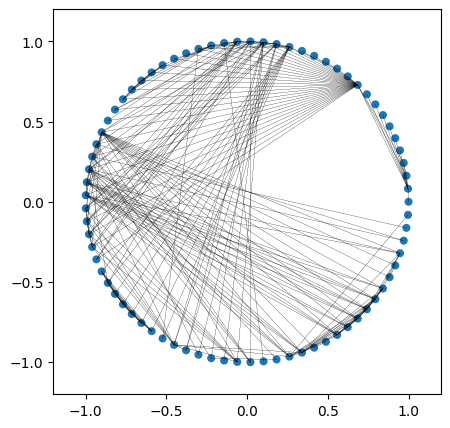

In [83]:
plot_circular_graph(adj_matrix=adj_matrix)